In [1]:
import jax 
from utils.train import * 
from utils.utils import *
from utils.eval import *
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

2023-11-03 01:18:35.873477: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


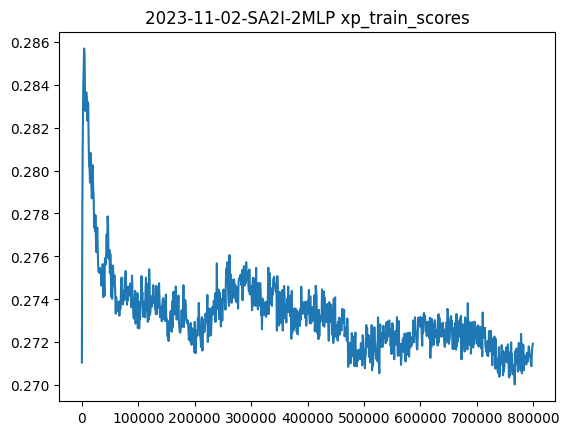

In [2]:
rewards = np.load("results/2023-11-02-SA2I-2MLP/xp_train_scores")
scaled_iterations = [x * 800 for x in range(1000)]
plt.title(label="2023-11-02-SA2I-2MLP xp_train_scores")
plt.plot(scaled_iterations, rewards)

In [4]:
class A2ICoded(nn.Module):
    hidden: int
    num_heads: int
    batch_size: int
    emb_dim: int
    N: int
    qkv_features: int
    out_features: int

    def setup(self):
        self.fc1 = nn.Dense(self.hidden)
        self.fc2 = nn.Dense(self.hidden)
        self.fc3 = nn.Dense(1)
        self.attn = nn.SelfAttention(self.num_heads, qkv_features=self.qkv_features, out_features=self.out_features)
        self.SA2IAttn = single_head_SA2IAttn(qkv_features=self.qkv_features, batch_size=self.batch_size)

    def observation_shaping(self, sp, h1, h2):
        sp = jnp.concatenate((jnp.repeat(jnp.array([1, 0, 0]), self.batch_size).reshape(self.batch_size, 3), sp), axis=-1)
        h1 = jnp.concatenate((jnp.repeat(jnp.array([0, 1, 0]), self.batch_size * self.N).reshape(self.batch_size, self.N, 3), h1), axis=-1)
        h2 = jnp.concatenate((jnp.repeat(jnp.array([0, 1, 0]), self.batch_size * self.N).reshape(self.batch_size, self.N, 3), h2), axis=-1)
        result = jnp.concatenate((sp[:, jnp.newaxis, :], h1, h2), axis=1)
        return result

    def actions_shaping(self, h2):
        return jnp.concatenate((jnp.repeat(jnp.array([0, 0, 1]), self.batch_size * self.N).reshape(self.batch_size, self.N, 3), h2), axis=-1)

    def __call__(self, sp, h1, h2):
        def forward_pass(observation, action):
            x = jnp.concatenate((observation, action[:, jnp.newaxis, :]), axis=1)
            x = self.attn(x)
            x = jnp.mean(x, axis=1)
            x = self.fc1(x)
            x = nn.relu(x)
            # x = self.fc2(x)
            # x = nn.relu(x)
            x = self.fc3(x)
            
            return x
        vmap_forward_pass = jax.vmap(forward_pass, in_axes=(None, 1), out_axes=1)
        observation = self.observation_shaping(sp, h1, h2)
        actions = self.actions_shaping(h2)
        q_values = vmap_forward_pass(observation, actions).reshape(self.batch_size, -1)
        return q_values

In [8]:
config = {
    "debug":True,
    "N": 5,
    "feature_dim": 3, # this the number of classes under different features set, e.g. dim = 3 for 0, 1, 2
    "emb_dim":9,
    "qkv_features":9,
    "out_features":9,
    "num_episodes": 4000000,
    "mlp_hidden": 128,
    "batch_size": 500,
    "learning_rate": 0.0001,
    "num_agents": 6,
    "PRNGkey": 0,
    "eval_rng":12345,
    "num_heads": 1,
    "eval_runs":10,
    "eps_min":0.01,
    "eps_max":0.95,
    "K":50000,
    "logging":True,
	"xpeval_print":True
    }

init_sp = jnp.zeros((config["batch_size"], 2 * config["feature_dim"]), jnp.float32)
init_h1 = jnp.zeros((config["batch_size"], config["N"], 2 * config["feature_dim"]), jnp.float32)
init_h2 = jnp.zeros((config["batch_size"], config["N"], 2 * config["feature_dim"]), jnp.float32)
init_rng = jax.random.PRNGKey(0)


hinter = A2ICoded(hidden=config["mlp_hidden"],
                 num_heads=config["num_heads"],
                 batch_size=config["batch_size"],
                 emb_dim=config["emb_dim"],
                 N=config["N"],
                 qkv_features=config["qkv_features"],
                 out_features=config["out_features"])
        
        
        
guesser = A2ICoded(hidden=config["mlp_hidden"],
				num_heads=config["num_heads"],
				batch_size=config["batch_size"],
				emb_dim=config["emb_dim"],
				N=config["N"],
				qkv_features=config["qkv_features"],
				out_features=config["out_features"])


100%|██████████| 10/10 [00:02<00:00,  4.60it/s]


0.6384


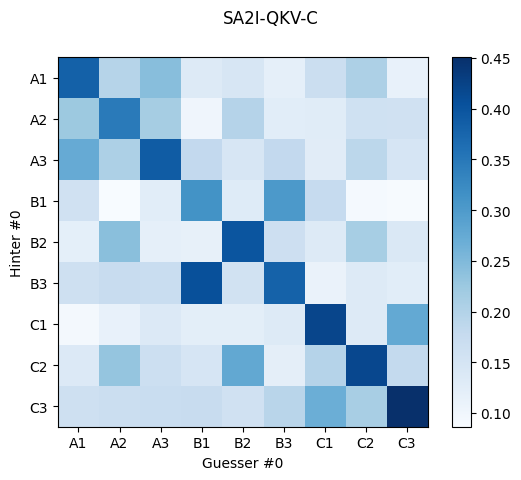

In [10]:
hinter_idx = 0
guesser_idx = 0
h_tree = load_trainstate(f"checkpoints/2023-11-02-SA2I-2MLP/hinter_{hinter_idx}")
g_tree = load_trainstate(f"checkpoints/2023-11-02-SA2I-2MLP/guesser_{guesser_idx}")

t_state_h = create_train_state(hinter, init_sp, init_h1, init_h2, init_rng, config["learning_rate"], params=h_tree["params"])
t_state_g = create_train_state(guesser, init_sp, init_h1, init_h2, init_rng, config["learning_rate"], params=g_tree["params"] )

rewards, conditional_prob = play_eval(t_state_h, t_state_g, init_rng, config)
print(rewards)

labels = [f"{char}{num}" for char in "ABC" for num in range(1, 4)]
fig, ax = plt.subplots()
cax = ax.imshow(conditional_prob, cmap='Blues')
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel(f'Guesser #{guesser_idx}')
ax.set_ylabel(f'Hinter #{hinter_idx}')
fig.suptitle('SA2I-QKV-C') 
cbar = fig.colorbar(cax, ax=ax)

plt.show()

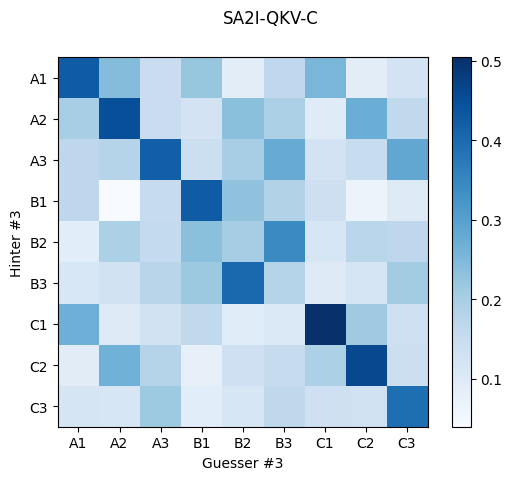

100%|██████████| 10/10 [00:01<00:00,  5.21it/s]


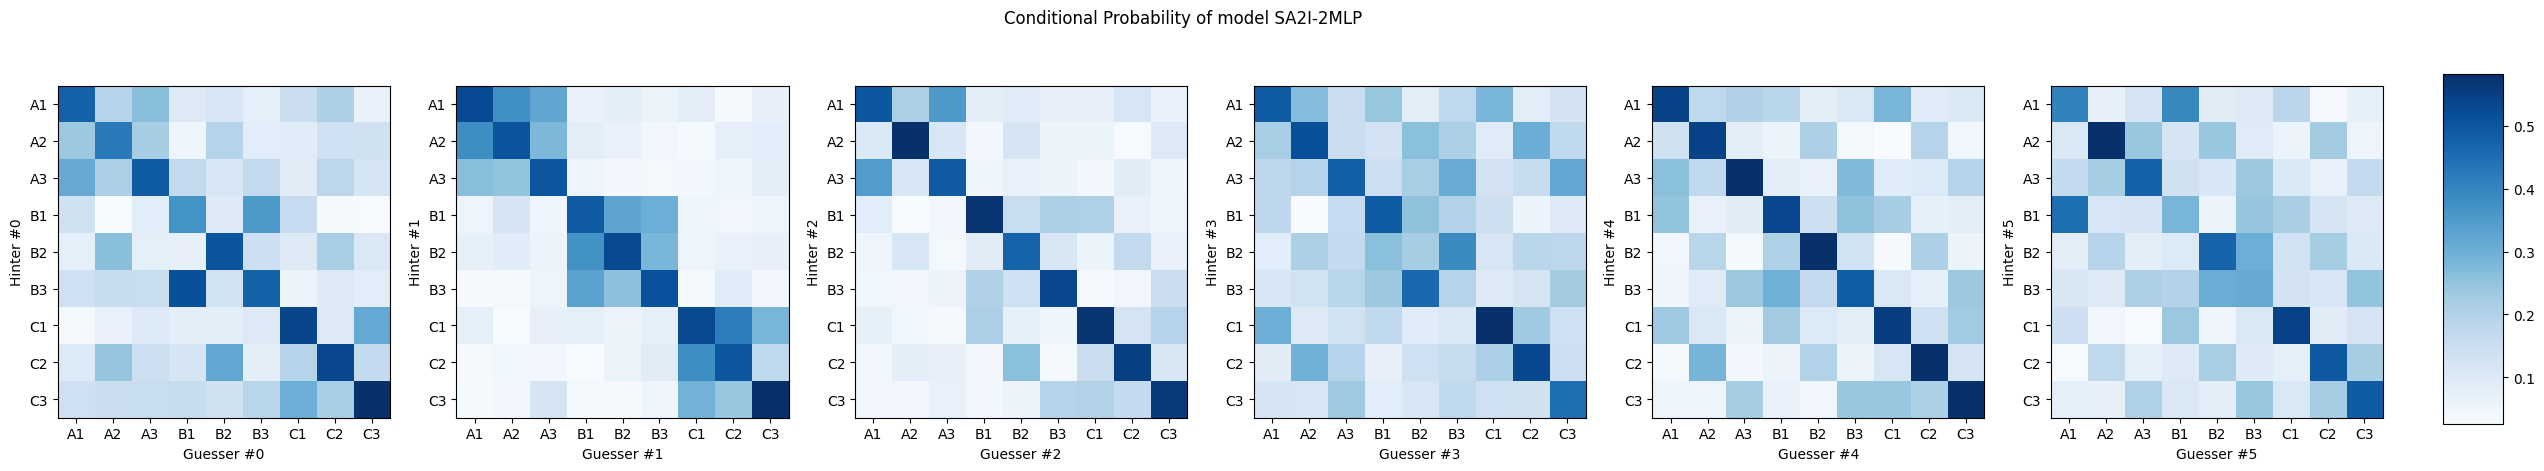

In [6]:
labels = [f"{char}{num}" for char in "ABC" for num in range(1, 4)]
fig, axs = plt.subplots(1, 6, figsize=(30, 5))  # 1 row, 4 columns, and you can adjust figsize as needed

for i, ax in enumerate(axs):
    guesser_idx = i
    hinter_idx = i  # Replace with how you determine hinter_idx if it's different from guesser_idx
    h_tree = load_trainstate(f"checkpoints/2023-11-02-SA2I-2MLP/hinter_{hinter_idx}")
    g_tree = load_trainstate(f"checkpoints/2023-11-02-SA2I-2MLP/guesser_{guesser_idx}")

    t_state_h = create_train_state(hinter, init_sp, init_h1, init_h2, init_rng, config["learning_rate"], params=h_tree["params"])
    t_state_g = create_train_state(guesser, init_sp, init_h1, init_h2, init_rng, config["learning_rate"], params=g_tree["params"] )

    _, conditional_prob = play_eval(t_state_h, t_state_g, init_rng, config)
    cax = ax.imshow(conditional_prob, cmap='Blues')  # Use the i-th conditional probability matrix
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel(f'Guesser #{guesser_idx}')
    ax.set_ylabel(f'Hinter #{hinter_idx}')
    # ax.set_title(f'Subplot {i}')  # Or you can put any title you want

# Create an axis for the colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # This adds an axis for the colorbar
fig.colorbar(cax, cax=cbar_ax)
fig.suptitle('Conditional Probability of model SA2I-2MLP') 
# plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect to not overlap with the colorbar
plt.savefig("results/2023-11-02-SA2I-2MLP/cond_prob")
plt.show()

In [9]:
agents = []
for i in range(6):
	h_tree = load_trainstate(f"checkpoints/2023-11-02-SA2I-2MLP/hinter_{i}")
	g_tree = load_trainstate(f"checkpoints/2023-11-02-SA2I-2MLP/guesser_{i}")
	t_state_h = create_train_state(hinter, init_sp, init_h1, init_h2, init_rng, config["learning_rate"], params=h_tree["params"])
	t_state_g = create_train_state(guesser, init_sp, init_h1, init_h2, init_rng, config["learning_rate"], params=g_tree["params"] )
	agents.append([t_state_h, t_state_g])

xp_result = xp_eval(agents, config)

100%|██████████| 10/10 [00:01<00:00,  5.16it/s]


Hinter0, Guesser0, Reward: 0.6372000575065613


100%|██████████| 10/10 [00:02<00:00,  4.98it/s]


Hinter0, Guesser1, Reward: 0.3142000138759613


100%|██████████| 10/10 [00:02<00:00,  4.95it/s]


Hinter0, Guesser2, Reward: 0.4138000011444092


100%|██████████| 10/10 [00:02<00:00,  4.63it/s]


Hinter0, Guesser3, Reward: 0.3206000328063965


100%|██████████| 10/10 [00:02<00:00,  4.63it/s]


Hinter0, Guesser4, Reward: 0.42319998145103455


100%|██████████| 10/10 [00:02<00:00,  4.98it/s]


Hinter0, Guesser5, Reward: 0.33640000224113464


100%|██████████| 10/10 [00:02<00:00,  4.84it/s]


Hinter1, Guesser0, Reward: 0.2985999882221222


100%|██████████| 10/10 [00:01<00:00,  5.01it/s]


Hinter1, Guesser1, Reward: 0.5734000205993652


100%|██████████| 10/10 [00:02<00:00,  4.84it/s]


Hinter1, Guesser2, Reward: 0.4270000159740448


100%|██████████| 10/10 [00:02<00:00,  4.72it/s]


Hinter1, Guesser3, Reward: 0.3222000002861023


100%|██████████| 10/10 [00:01<00:00,  5.29it/s]


Hinter1, Guesser4, Reward: 0.3522000014781952


100%|██████████| 10/10 [00:01<00:00,  5.33it/s]


Hinter1, Guesser5, Reward: 0.31960004568099976


100%|██████████| 10/10 [00:01<00:00,  5.31it/s]


Hinter2, Guesser0, Reward: 0.3806000053882599


100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


Hinter2, Guesser1, Reward: 0.45260000228881836


100%|██████████| 10/10 [00:02<00:00,  4.80it/s]


Hinter2, Guesser2, Reward: 0.5214000344276428


100%|██████████| 10/10 [00:02<00:00,  4.81it/s]


Hinter2, Guesser3, Reward: 0.3296000063419342


100%|██████████| 10/10 [00:02<00:00,  4.59it/s]


Hinter2, Guesser4, Reward: 0.42080003023147583


100%|██████████| 10/10 [00:02<00:00,  4.92it/s]


Hinter2, Guesser5, Reward: 0.3938000202178955


100%|██████████| 10/10 [00:02<00:00,  4.64it/s]


Hinter3, Guesser0, Reward: 0.3319999873638153


100%|██████████| 10/10 [00:02<00:00,  4.59it/s]


Hinter3, Guesser1, Reward: 0.3286000192165375


100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


Hinter3, Guesser2, Reward: 0.34940001368522644


100%|██████████| 10/10 [00:01<00:00,  5.11it/s]


Hinter3, Guesser3, Reward: 0.6396000385284424


100%|██████████| 10/10 [00:01<00:00,  5.31it/s]


Hinter3, Guesser4, Reward: 0.3404000401496887


100%|██████████| 10/10 [00:01<00:00,  5.31it/s]


Hinter3, Guesser5, Reward: 0.36559998989105225


100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


Hinter4, Guesser0, Reward: 0.4099999964237213


100%|██████████| 10/10 [00:02<00:00,  4.86it/s]


Hinter4, Guesser1, Reward: 0.36000001430511475


100%|██████████| 10/10 [00:02<00:00,  4.93it/s]


Hinter4, Guesser2, Reward: 0.43640002608299255


100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


Hinter4, Guesser3, Reward: 0.3442000150680542


100%|██████████| 10/10 [00:02<00:00,  4.36it/s]


Hinter4, Guesser4, Reward: 0.5802001357078552


100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


Hinter4, Guesser5, Reward: 0.4498000144958496


100%|██████████| 10/10 [00:02<00:00,  4.80it/s]


Hinter5, Guesser0, Reward: 0.32840004563331604


100%|██████████| 10/10 [00:02<00:00,  4.92it/s]


Hinter5, Guesser1, Reward: 0.3460000157356262


100%|██████████| 10/10 [00:02<00:00,  4.78it/s]


Hinter5, Guesser2, Reward: 0.39340001344680786


100%|██████████| 10/10 [00:01<00:00,  5.04it/s]


Hinter5, Guesser3, Reward: 0.3465999960899353


100%|██████████| 10/10 [00:01<00:00,  5.29it/s]


Hinter5, Guesser4, Reward: 0.45760002732276917


100%|██████████| 10/10 [00:01<00:00,  5.32it/s]

Hinter5, Guesser5, Reward: 0.5690000653266907


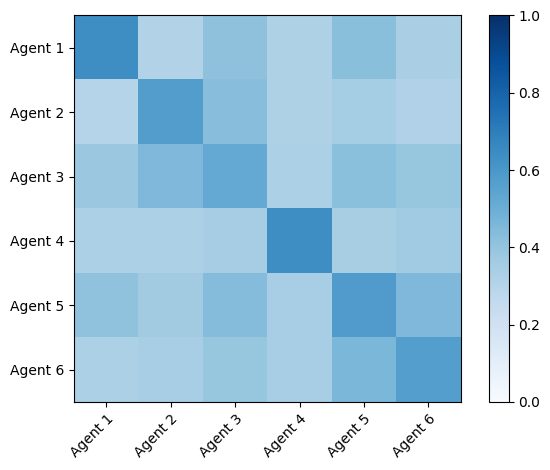

In [10]:
labels = [f"Agent {i}" for i in range(1, config["num_agents"]+1)]
fig, ax = plt.subplots()
cax = ax.imshow(xp_result, cmap='Blues', vmin=0, vmax=1)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
cbar = fig.colorbar(cax, ax=ax)

plt.tight_layout()
plt.savefig("results/2023-11-02-SA2I-2MLP/cond_prob")
plt.show()

In [ ]:
from models.SA2I import * 
model_test()

(256, 5)


In [ ]:
a = jnp.arange(16).reshape(2, 2, 2, 2)
dim = a.ndim
axes = jnp.arange(dim)
a = jnp.repeat(a, 4, axis=0)
a = jnp.transpose(a, axes=(1, 0,)+axes[1:])
print(a)

AttributeError: 'tuple' object has no attribute 'shape'